# Regression linéaire sur les retards de la SNCF

**1. Importation des modules et des données**

In [173]:
#importation des modules nécessaires
import pandas as pd
import requests
import matplotlib.pyplot as plt
import math
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [174]:
from sklearn import svm
import numpy as np
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

In [175]:
#importation des fonctions créées pour le projet
from fonctions import *

In [176]:
"""
#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule

import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

session = requests.Session()
retry = Retry(connect=3, backoff_factor=0.5)
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

session.get(url_retards)
"""

'\n#si erreur "Max retries exceeded with url" dans la cellule suivante, utiliser cette cellule\n\nimport requests\nfrom requests.adapters import HTTPAdapter\nfrom urllib3.util.retry import Retry\n\nsession = requests.Session()\nretry = Retry(connect=3, backoff_factor=0.5)\nadapter = HTTPAdapter(max_retries=retry)\nsession.mount(\'http://\', adapter)\nsession.mount(\'https://\', adapter)\n\nsession.get(url_retards)\n'

In [177]:
#importation des données depuis l'API SNCF
df_retards = importer('https://ressources.data.sncf.com/api/v2/catalog/datasets/regularite-mensuelle-tgv-aqst/exports/json?limit=-1&offset=0&timezone=UTC')
df_retards.head(2)

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,...,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,LAVAL,PARIS MONTPARNASSE,86,208,0,None,84,7.287897,...,19,5.044792,5,2,16.129032,35.483871,19.354839,22.580645,3.225806,3.225806
1,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,None,213,8.479969,...,32,5.363539,9,4,20.000000,35.000000,16.666667,16.666667,8.333333,3.333333


**2. nettoyage et préparation des données pour la regression**

In [178]:
#on retire les colonnes de commentaires qui sont generalement vides
df_retards = df_retards.drop('commentaire_annulation', axis = 1)
df_retards = df_retards.drop('commentaire_retards_depart', axis = 1)
df_retards = df_retards.drop('commentaires_retard_arrivee', axis = 1)

In [179]:
#on retire aussi les colonnes de NaN et dont les retards valent 0 qui ne nous interessent pas ici
df_retards.dropna(inplace = True)
df_retards = df_retards.drop(df_retards[df_retards['nb_train_retard_arrivee']==0].index)

In [180]:
#on liste les différentes causes de retards du dataframe
causes_retards = ['cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']
causes_retards_large = ['nb_annulation', 'cause_materiel_roulant', 'cause_infra', 'cause_gestion_trafic', 'cause_externe', 'cause_gestion_gare', 'cause_prise_en_charge_voyageurs', 'nb_train_prevu']

In [181]:
#on passe les causes de retards en niveau plutôt qu'en pourcentage pour homogénéiser les données
#on utilise la fonction niveau qui est dans le fichier fonctions.py
niveau(df_retards,df_retards['nb_train_retard_arrivee'], causes_retards)


,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LAVAL,PARIS MONTPARNASSE,86,208,0,84,7.287897,3.016987,...,19.354839,22.580645,3.225806,3.225806,12.419355,19.516129,10.645161,8.870968,1.774194,1.774194
1,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
2,2018-01,National,PARIS MONTPARNASSE,BORDEAUX ST JEAN,143,775,7,148,9.377815,1.582530,...,11.666667,40.000000,1.666667,0.000000,31.600000,19.750000,9.216667,17.116667,1.316667,0.000000
3,2018-01,National,PARIS MONTPARNASSE,RENNES,97,590,1,79,10.088608,1.029655,...,18.987342,24.050633,2.531646,0.000000,25.734177,44.696203,20.316456,13.544304,2.708861,0.000000
4,2018-01,National,ST MALO,PARIS MONTPARNASSE,158,92,0,2,1.225000,0.062500,...,0.000000,11.111111,0.000000,0.000000,1.111111,6.666667,0.000000,2.222222,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,QUIMPER,PARIS MONTPARNASSE,231,231,0,18,15.055556,1.173913,...,8.695652,13.043478,8.695652,13.043478,3.000000,8.000000,2.000000,5.000000,2.000000,3.000000
7301,2022-11,National,RENNES,PARIS MONTPARNASSE,104,795,0,331,9.243907,3.858889,...,16.260163,7.317073,7.317073,13.008130,9.000000,42.000000,20.000000,27.000000,9.000000,16.000000
7302,2022-11,National,STRASBOURG,NANTES,325,50,0,5,3.043333,0.337000,...,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000
7303,2022-11,National,STRASBOURG,PARIS EST,116,548,1,320,11.520833,6.773644,...,67.889908,8.256881,5.504587,5.504587,9.000000,7.000000,74.000000,7.000000,6.000000,6.000000


In [182]:
#on copie la dataframe initiale par securite
df_retards_initial = df_retards.copy()
#df_retards = df_retards_initial.copy()
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LAVAL,PARIS MONTPARNASSE,86,208,0,84,7.287897,3.016987,...,19.354839,22.580645,3.225806,3.225806,12.419355,19.516129,10.645161,8.870968,1.774194,1.774194
1,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,406,1,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,17.500000,36.750000,17.500000,21.000000,8.750000,3.500000
2,2018-01,National,PARIS MONTPARNASSE,BORDEAUX ST JEAN,143,775,7,148,9.377815,1.582530,...,11.666667,40.000000,1.666667,0.000000,31.600000,19.750000,9.216667,17.116667,1.316667,0.000000
3,2018-01,National,PARIS MONTPARNASSE,RENNES,97,590,1,79,10.088608,1.029655,...,18.987342,24.050633,2.531646,0.000000,25.734177,44.696203,20.316456,13.544304,2.708861,0.000000
4,2018-01,National,ST MALO,PARIS MONTPARNASSE,158,92,0,2,1.225000,0.062500,...,0.000000,11.111111,0.000000,0.000000,1.111111,6.666667,0.000000,2.222222,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,QUIMPER,PARIS MONTPARNASSE,231,231,0,18,15.055556,1.173913,...,8.695652,13.043478,8.695652,13.043478,3.000000,8.000000,2.000000,5.000000,2.000000,3.000000
7301,2022-11,National,RENNES,PARIS MONTPARNASSE,104,795,0,331,9.243907,3.858889,...,16.260163,7.317073,7.317073,13.008130,9.000000,42.000000,20.000000,27.000000,9.000000,16.000000
7302,2022-11,National,STRASBOURG,NANTES,325,50,0,5,3.043333,0.337000,...,0.000000,0.000000,0.000000,33.333333,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000
7303,2022-11,National,STRASBOURG,PARIS EST,116,548,1,320,11.520833,6.773644,...,67.889908,8.256881,5.504587,5.504587,9.000000,7.000000,74.000000,7.000000,6.000000,6.000000


In [194]:
#Recalibrage des données 
features = df_retards[causes_retards_large]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[causes_retards_large] = features
df_retards

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,...,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
0,2018-01,National,LAVAL,PARIS MONTPARNASSE,86,-0.290686,-0.399767,84,7.287897,3.016987,...,19.354839,22.580645,3.225806,3.225806,0.888829,1.393744,0.424525,0.063329,-0.196385,-0.176550
1,2018-01,National,LE MANS,PARIS MONTPARNASSE,56,0.880339,-0.360874,213,8.479969,4.567119,...,16.666667,16.666667,8.333333,3.333333,1.646281,3.428497,1.249301,1.345632,2.032280,0.246998
2,2018-01,National,PARIS MONTPARNASSE,BORDEAUX ST JEAN,143,3.062704,-0.127510,148,9.377815,1.582530,...,11.666667,40.000000,1.666667,0.000000,3.748388,1.421356,0.252648,0.935079,-0.342558,-0.611973
3,2018-01,National,PARIS MONTPARNASSE,RENNES,97,1.968565,-0.360874,79,10.088608,1.029655,...,18.987342,24.050633,2.531646,0.000000,2.873878,4.366682,1.588178,0.557402,0.102227,-0.611973
4,2018-01,National,ST MALO,PARIS MONTPARNASSE,158,-0.976741,-0.399767,2,1.225000,0.062500,...,0.000000,11.111111,0.000000,0.000000,-0.797068,-0.123355,-0.856305,-0.639588,-0.763213,-0.611973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7300,2022-11,National,QUIMPER,PARIS MONTPARNASSE,231,-0.154658,-0.399767,18,15.055556,1.173913,...,8.695652,13.043478,8.695652,13.043478,-0.515462,0.034067,-0.615664,-0.345917,-0.124243,0.124288
7301,2022-11,National,RENNES,PARIS MONTPARNASSE,104,3.180989,-0.399767,331,9.243907,3.858889,...,16.260163,7.317073,7.317073,13.008130,0.379052,4.048349,1.550102,1.979963,2.112151,3.314751
7302,2022-11,National,STRASBOURG,NANTES,325,-1.225140,-0.399767,5,3.043333,0.337000,...,0.000000,0.000000,0.000000,33.333333,-0.962719,-0.910469,-0.856305,-0.663082,-0.763213,-0.366553
7303,2022-11,National,STRASBOURG,PARIS EST,116,1.720165,-0.360874,320,11.520833,6.773644,...,67.889908,8.256881,5.504587,5.504587,0.379052,-0.084000,8.047402,-0.134473,1.153697,0.860548


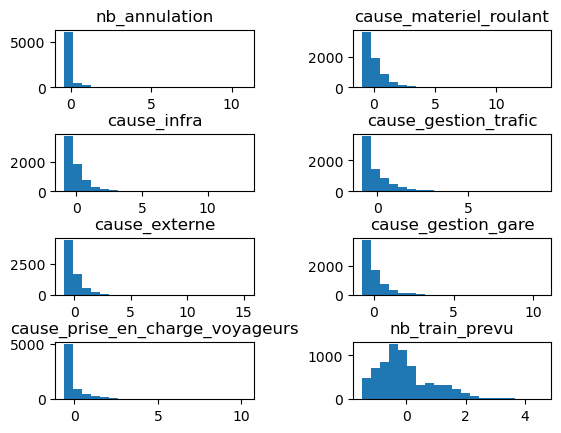

In [195]:
#Visualisation des données
for i in range(len(causes_retards_large[:])):
    plt.subplot(4,2,i+1)
    plt.hist(df_retards[causes_retards_large[i]], bins = 20)
    plt.title(causes_retards_large[i])
    plt.gcf().subplots_adjust(wspace = 0.5, hspace = 0.8)

In [196]:
#Les données sont correctes, nous ne passeront pas au log ici

**3. Première regression à une variable**

Regression "rapide", pour comparer le R^2, avant de vite passer au cas multivarié

In [197]:
#Appel de la fonction regression du fichier fonctions

reg = regression(df_retards[['cause_externe']], df_retards[['nb_train_retard_arrivee']])
results = reg[0]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     7439.
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:14:08   Log-Likelihood:                -25134.
No. Observations:                5715   AIC:                         5.027e+04
Df Residuals:                    5713   BIC:                         5.029e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            34.7398      0.260    133.502

In [198]:
#Le R^2, représentatif du pouvoir explicatif du modèle, est de 0.561 (1 correspondant à une prédiction parfaite)


**4. Regression à plusieurs variables**

In [199]:
#On passe maintenant à une regression à plusieurs variables
reg = regression(df_retards[causes_retards_large], df_retards[['nb_train_retard_arrivee']])
results = reg[0]
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 4.614e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        16:14:10   Log-Likelihood:                -15453.
No. Observations:                5715   AIC:                         3.092e+04
Df Residuals:                    5706   BIC:                         3.098e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     


**Analyse des coefficients**

Le R^2 de la regression est satisfaisant et a largement augmenté (en ajoutant des variables, on augmente le pouvoir explicatif du modèle sous certaines conditions). La variable nb_annulation n'est pas significative et nb_train_prevu n'est pas significative au seuil de 1%. Le reste des variables sont significatives.
Le coefficient le plus élevé est celui de cause_externe. Il signifie qu'une cause externe provoque le retard d'environ 9 trains en moyenne. On va utiliser le lasso pour sélectionner les variables.

In [200]:
#récupération des variables xTest et yTest renvoyées par la fonction regression
xTest = reg[2]
yTest = reg[4]
yPred = results.predict(xTest)
epsilon = yTest - yPred
xTest

,const,nb_annulation,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs,nb_train_prevu
2932,1.0,-0.127510,-0.651583,0.075134,-0.102995,-0.212615,-0.763213,-0.355883,-0.651456
689,1.0,-0.399767,-0.483515,-0.277967,-0.469561,-0.761252,-0.420908,-0.349023,-0.296600
248,1.0,-0.399767,-0.962719,-0.910469,-0.735985,-0.768804,-0.763213,-0.611973,-1.343425
2044,1.0,-0.088616,0.595904,0.817604,-0.478937,0.672857,-0.095199,-0.355398,-0.207886
690,1.0,-0.360874,-0.068205,-0.202067,-0.254703,-0.663082,-0.763213,-0.366553,-0.964912
...,...,...,...,...,...,...,...,...,...
7200,1.0,-0.166404,1.571738,-0.320134,-0.014063,0.711301,-0.443728,-0.611973,2.696019
4995,1.0,-0.166404,0.703674,1.009073,1.588915,0.307171,0.210701,-0.362595,0.519569
3268,1.0,5.162056,-0.164045,-0.657468,-0.856305,-0.647979,-0.420908,0.439828,1.134653
4378,1.0,-0.360874,2.018995,0.270202,0.226578,-0.451638,-0.443728,-0.366553,-0.249286


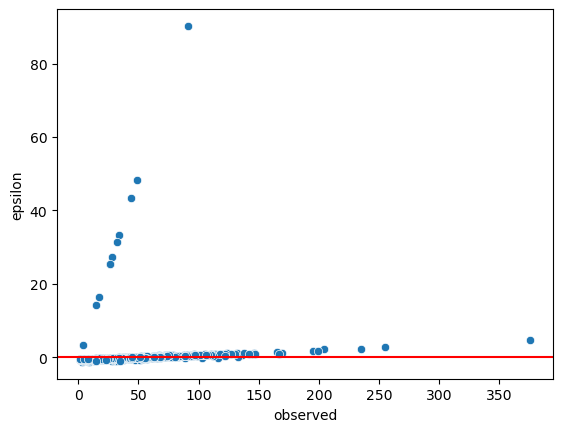

In [201]:
#Nuage de points des valeurs observées
tempdf = pd.DataFrame({"prediction": yPred, "observed": yTest,
                       "epsilon": yTest - yPred})

fig = plt.figure()
g = sns.scatterplot(data = tempdf, x = "observed", y = "epsilon")
g.axhline(0, color = "red")

# Selection de variables avec le lasso

In [202]:
df_retards = df_retards_initial.copy()
#on commence par refaire une regression

reg = regression(df_retards[causes_retards_large], df_retards[['nb_train_retard_arrivee']])
results = reg[0]
xTrain = reg[1]
yTrain = reg[3]

In [203]:
#Estimation du modèle LASSO
lasso1 = Lasso(fit_intercept=True,normalize=False, alpha = 0.7).fit(xTrain,yTrain)
x = sm.add_constant(df_retards[causes_retards_large])

#selection de variables
features_selec = x.columns[np.abs(lasso1.coef_)>0].tolist()
features_selec 

/opt/mamba/lib/python3.10/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


['cause_materiel_roulant',
 'cause_infra',
 'cause_gestion_trafic',
 'cause_externe',
 'cause_gestion_gare',
 'cause_prise_en_charge_voyageurs',
 'nb_train_prevu']

In [204]:
#recalibration des données
features = df_retards[features_selec]
features = StandardScaler().fit(features.values).transform(features.values)
df_retards[features_selec] = features

In [205]:
#on ne retient pas la variable nb_annulation ce qui est assez intuitif

In [94]:
#corrélations entre les variables sélectionnées
corr = df_retards[features_selec].corr()

plt.figure()
p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)
p

/tmp/ipykernel_659/2425215618.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  p = corr.style.background_gradient(cmap='coolwarm', axis=None).set_precision(2)


,nb_train_prevu,cause_materiel_roulant,cause_infra,cause_gestion_trafic,cause_externe,cause_gestion_gare,cause_prise_en_charge_voyageurs
nb_train_prevu,1.00,0.61,0.56,0.48,0.53,0.53,0.51
cause_materiel_roulant,0.61,1.00,0.47,0.52,0.43,0.53,0.36
cause_infra,0.56,0.47,1.00,0.56,0.50,0.41,0.31
cause_gestion_trafic,0.48,0.52,0.56,1.00,0.45,0.48,0.37
cause_externe,0.53,0.43,0.50,0.45,1.00,0.35,0.28
cause_gestion_gare,0.53,0.53,0.41,0.48,0.35,1.00,0.46
cause_prise_en_charge_voyageurs,0.51,0.36,0.31,0.37,0.28,0.46,1.00


<Figure size 640x480 with 0 Axes>

In [95]:
#On vérifie que les variables ne sont pas exagérément correlées

In [96]:
#regression avec les variables selectionnées par le lasso
results_2 = regression(df_retards[features_selec], df_retards[['nb_train_retard_arrivee']])[0]

print(results_2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 6.678e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:01:25   Log-Likelihood:                -14841.
No. Observations:                5715   AIC:                         2.970e+04
Df Residuals:                    5707   BIC:                         2.975e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

In [97]:
#On va retirer la variable nb_train_prevu qui n'est pas significative au seuil de 1% et qui est moins intuitive

In [99]:
#regression finale 
reg_3 = regression(df_retards[features_selec[1:]], df_retards[['nb_train_retard_arrivee']])
results_3 = reg_3[0]

print(results_3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 6.334e+04
Date:                Sat, 17 Dec 2022   Prob (F-statistic):               0.00
Time:                        14:01:34   Log-Likelihood:                -15378.
No. Observations:                5715   AIC:                         3.077e+04
Df Residuals:                    5708   BIC:                         3.082e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

**Conclusion** : selon cette regression, l'incident impliquant le plus de retard est la cause externe (météo...). Lorsqu'on observe un incident externe de plus, on prédit le retard de 9 trains supplémentaires. Malheureusement, la SNCF ne peut pas vraiment agir sur ce genre d'incidents. 
En revanche, si la SNCF trouvait par exemple un moyen de supprimer les problèmes de matériel roulant, elle éviterait le retard de 6 à 7 trains par ligne et par mois. 
Ce qui est plus embêtant pour la SNCF est qu'aucune cause de retard ne "sort du lot" en terme d'impact donc la SNCF doit agir sur l'ensemble de ces causes pour réduire les retards.
